In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from sklearn.utils import check_random_state
from scipy.optimize import fmin_l_bfgs_b
import jax
import jax.numpy as jnp
from time import time

# parameters

In [36]:
nb_freqs = 3
freq_max = 8
sr = 500
random_state = 10
rng = check_random_state(random_state)
cste = 1.
max_dilation = 1.05 * cste
max_shift = 40
a_star = 1.02 * cste
b_star = -5
nb_points_grid = 100

# create signal $s$

In [25]:
def create_one_signal(nb_freqs=3, freq_max=8, sr=100, rng=None):
    heights = rng.exponential(scale=1, size=nb_freqs)
    frequencies = rng.uniform(low=1, high=freq_max, size=nb_freqs)
    t = np.linspace(0, 1, sr, endpoint=False)
    s = np.zeros(sr)
    for i in range(nb_freqs):
        s += heights[i] * np.sin(2 * np.pi * frequencies[i] * t)
    return s

s = create_one_signal(nb_freqs=nb_freqs, freq_max=freq_max, sr=sr, rng=rng)

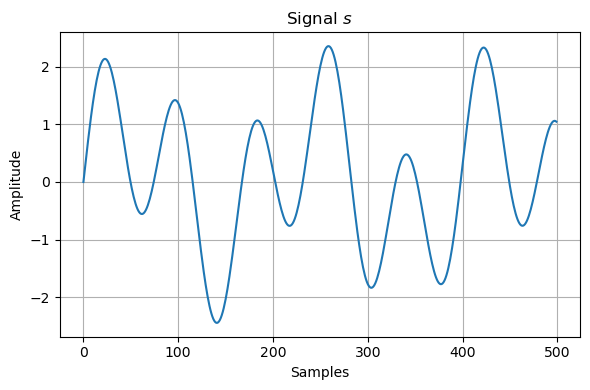

In [26]:
# plot S
plt.figure(figsize=(6, 4))
plt.plot(s)
plt.grid()
plt.title("Signal $s$")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# apply delay

In [27]:
def apply_both_delays_1d(s, a=1, b=0, t0=0):
    t = jnp.arange(len(s)) - t0
    t_ab = (t - b) * a / cste  # XXX
    # t_ab = (a / cste) * t - b  # XXX
    s_ab = jnp.interp(x=t_ab, xp=t, fp=s, left=0, right=0)
    return s_ab

In [28]:
s_d = apply_both_delays_1d(s, a=a_star, b=b_star)

# loss

In [29]:
@np.vectorize
def loss(a, b):
    s_ = apply_both_delays_1d(s, a=a, b=b)
    return jnp.mean((s_d - s_) ** 2)

In [30]:
a_grid = np.linspace(1/max_dilation*cste**2, max_dilation, nb_points_grid, endpoint=False)  # XXX
b_grid = np.linspace(-max_shift, max_shift, nb_points_grid, endpoint=False)
A, B = np.meshgrid(a_grid, b_grid)
L = loss(A, B)

# plot

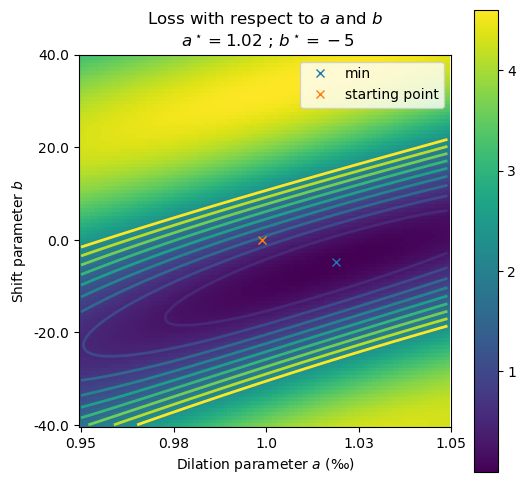

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))

img = ax.imshow(L, origin='lower')
plt.xlabel("Dilation parameter $a$ (‰)")
plt.ylabel("Shift parameter $b$")
plt.title(f"Loss with respect to $a$ and $b$\n $a^\star={a_star}$ ; $b^\star={b_star}$")
plt.colorbar(img)

# minimum and starting point
plt.plot(np.argmin(np.abs(a_grid - a_star)), np.argmin(np.abs(b_grid - b_star)), 'x', label='min')
plt.plot(np.argmin(np.abs(a_grid - cste)), nb_points_grid/2, 'x', label='starting point')  # XXX

# contours
# cset = plt.contour(L, np.arange(0, 2, 0.1), linewidths=2)
# cset = plt.contour(L, np.linspace(0, np.max(L)/2, 11)[1:], linewidths=2)
cset = plt.contour(L, np.linspace(0, np.max(L)/2, 10), linewidths=2)

# set ticks
xticks = yticks = np.linspace(0, nb_points_grid, 5)
xticklabels = np.round(np.linspace(1/max_dilation*cste**2, max_dilation, 5), 2)  # XXX
yticklabels = np.linspace(-max_shift, max_shift, 5)
ax.set(xticks=xticks, xticklabels=xticklabels, yticks=yticks, yticklabels=yticklabels)
plt.legend()
plt.show()

# gradient descent

In [15]:
def loss_jax(a_b, s1, s2):
    a, b = a_b
    s2_d = apply_both_delays_1d(s2, a=a, b=b)
    return jnp.mean((s1 - s2_d) ** 2)

grad = jax.grad(loss_jax)

In [16]:
alpha = 10
n_iter = 2000
a = cste
b = 0.
memory = []
for i in range(n_iter):
    ga, gb = grad((a, b), s_d, s)
    a = a - alpha * ga
    b = b - alpha * gb
    print(a, b)
    if i % 20 == 0:
        memory.append(np.array([a, b]))
memory = np.array(memory)

1000.3284 -1.2191849
1000.62427 -2.2894814
1000.8911 -3.2283168
1001.13184 -4.0504
1001.34906 -4.7686577
1001.545 -5.3940306
1001.7199 -5.932274
1001.87683 -6.3970723
1002.0189 -6.799355
1002.14636 -7.1437182
1002.2618 -7.4395623
1002.36707 -7.694514
1002.46265 -7.911654
1002.5503 -8.09725
1002.6315 -8.25746
1002.70636 -8.393335
1002.776 -8.508916
1002.84094 -8.606594
1002.9023 -8.689693
1002.9602 -8.759851
1003.01544 -8.819475
1003.06775 -8.868184
1003.1182 -8.91025
1003.1667 -8.944371
1003.2135 -8.972678
1003.2588 -8.996529
1003.30286 -9.015843
1003.34576 -9.031077
1003.38763 -9.042659
1003.42865 -9.05118
1003.46893 -9.057186
1003.5086 -9.061075
1003.5477 -9.063143
1003.5863 -9.063629
1003.62445 -9.062755
1003.66223 -9.060708
1003.69965 -9.057654
1003.73676 -9.053741
1003.7736 -9.049094
1003.81024 -9.043821
1003.8466 -9.038016
1003.8828 -9.031757
1003.9188 -9.025114
1003.95465 -9.018145
1003.99036 -9.010896
1004.0259 -9.003414
1004.0612 -8.995618
1004.0968 -8.988372
1004.13226 -8.980

In [17]:
# map to [0, 100] because of xytickslabels
def map_a(a, nb_points_grid=100, a_min=1/max_dilation*cste**2, a_max=max_dilation):
    return (a - a_min) / (a_max - a_min) * nb_points_grid

def map_b(b, nb_points_grid=100, b_min=-max_shift, b_max=max_shift):
    return (b - b_min) / (b_max - b_min) * nb_points_grid

memory_a = memory[:, 0]
new_a = map_a(memory_a, nb_points_grid=nb_points_grid, a_min=1/max_dilation*cste**2, a_max=max_dilation)
memory_b = memory[:, 1]
new_b = map_b(memory_b, nb_points_grid=nb_points_grid, b_min=-max_shift, b_max=max_shift)

memory_mapped = np.vstack([new_a, new_b]).T

# GIF

In [13]:
plot_gif = False
if plot_gif:
    # colors
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # background figure
    fig, ax = plt.subplots()
    img = ax.imshow(L, origin='lower')
    plt.xlabel("Dilation parameter $a$ (‰)")
    plt.ylabel("Shift parameter $b$")
    plt.title(f"Loss with respect to $a$ and $b$\n $a^\star={a_star}$ ; $b^\star={b_star}$")
    plt.colorbar(img)
    plt.plot(np.argmin(np.abs(a_grid - a_star)), np.argmin(np.abs(b_grid - b_star)), 'x', label='min')
    plt.plot(np.argmin(np.abs(a_grid - cste)), nb_points_grid/2, 'x', label='starting point')  # XXX
    cset = plt.contour(L, np.linspace(0, np.max(L)/2, 10), linewidths=2)
    xticks = yticks = np.linspace(0, nb_points_grid, 5)
    xticklabels = np.round(np.linspace(1/max_dilation*cste**2, max_dilation, 5), 2)  # XXX
    yticklabels = np.linspace(-max_shift, max_shift, 5)
    ax.set(xticks=xticks, xticklabels=xticklabels, yticks=yticks, yticklabels=yticklabels)
    plt.legend()

    # Initialize the points to be animated
    line, = ax.plot([], [], 'x', color=colors[1], markersize=2)

    # Initialize the data for the line
    x_data, y_data = [], []

    # Animation function
    def update(i):
        # Update the position of the point in each frame
        a_b = memory_mapped[i]
        x_data.append(a_b[0])
        y_data.append(a_b[1])

        # Update the line with all previous points
        line.set_data(x_data, y_data)

        return line,

    # Set the number of frames
    num_frames = len(memory_mapped)

    # Create animation
    ani = FuncAnimation(fig, update, frames=num_frames, blit=True)

    # Save the animation as a GIF
    results_dir = "/storage/store2/work/aheurteb/mvicad/lbfgsb_results/gifs/"
    gif_name = f"nbfreqs{nb_freqs}_freqmax{freq_max}_sr{sr}_randomstate{random_state}_a{a_star}_b{b_star}_cste{cste}"
    ani.save(results_dir + gif_name + '.gif', writer='imagemagick', fps=25)

    # Show the plot (if needed)
    plt.show()

# LBFGSB

In [32]:
val_and_grad = jax.jit(jax.value_and_grad(loss_jax))

def wrapper_loss_and_grad(a_b, s_d, s):
    loss, grad = val_and_grad(a_b, s_d, s)
    return loss, np.array(grad)

In [33]:
jax.config.update('jax_enable_x64', True)

In [35]:
# jit
start = time()
wrapper_loss_and_grad((cste, 0.), s_d, s)
print(f"time : {time() - start}")

time : 0.4080638885498047


In [37]:
# bounds
bounds = [(1/max_dilation*cste**2, max_dilation), (-max_shift, max_shift)]

In [38]:
# LBFGSB
res_lbfgsb = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad,
    x0=(cste, 0.),
    args=(s_d, s),
    bounds=bounds,
    disp=True,
    factr=0,
    pgtol=1e-6,
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01674D-01    |proj g|=  1.21918D-01

At iterate    1    f=  1.52391D-01    |proj g|=  9.76190D-02

At iterate    2    f=  4.83018D-02    |proj g|=  1.76780D-02

At iterate    3    f=  4.82993D-02    |proj g|=  4.68642D-02

At iterate    4    f=  4.82860D-02    |proj g|=  8.37225D-02

At iterate    5    f=  4.82481D-02    |proj g|=  8.38605D-02

At iterate    6    f=  4.81715D-02    |proj g|=  8.40217D-02

At iterate    7    f=  4.79555D-02    |proj g|=  8.42652D-02

At iterate    8    f=  4.73938D-02    |proj g|=  8.45734D-02

At iterate    9    f=  4.72129D-02    |proj g|=  8.45992D-02

At iterate   10    f=  4.47186D-02    |proj g|=  8.45860D-02

At iterate   11    f=  4.00622D-02    |proj g|=  8.36347D-02

At iterate   12    f=  2.80617D-02    |proj g|=  7.94324D-02

At iterate   13    f=  1.1

In [39]:
res_lbfgsb[0]

array([ 1.02      , -4.99999995])

# try with more complex data

Idea: use a loss that only contains the square norm part; see if we retrieve the parameters a and b. 

In [20]:
# params
m = 5
p = 2
n = 600
nb_intervals = 5
nb_freqs = 10
threshold = 0.1
cste = 1e3  # XXX
max_dilation = 1.1 * cste  # XXX
max_shift = 20
max_delay = (np.ceil((n + max_shift) * max_dilation / cste) - n).astype("int")  # XXX
t0 = 0
noise_data = 0.01  # 0.1
noise_model = 1
random_state = 431

In [21]:
def apply_both_delays_1d_cyclic(s, a=1, b=0, t0=0):
    n = len(s)
    s_concat = jnp.concatenate([s[n-max_delay:], s, s[:max_delay]])
    t_concat = jnp.arange(len(s_concat)) - max_delay - t0
    t = jnp.arange(len(s)) - t0
    t_ab = (t - b) * a / cste  # XXX
    s_ab = jnp.interp(x=t_ab, xp=t_concat, fp=s_concat)
    return s_ab

def apply_both_delays_2d_cyclic(S, a=None, b=None, t0=0):
    p, n = S.shape
    if a is None:
        a = jnp.ones(p)
    if b is None:
        b = jnp.zeros(p)
        
    S_concat = jnp.concatenate([S[:, n-max_delay:], S, S[:, :max_delay]], axis=1)
    t_concat = jnp.arange(S_concat.shape[1]) - max_delay - t0

    t = jnp.arange(n) - t0
    T = jnp.array([t] * p)
    T_ab = ((T.T - b) * a / cste).T  # XXX
    S_ab = jnp.array(
        [jnp.interp(x=T_ab[i], xp=t_concat, fp=S_concat[i], left=0, right=0)
         for i in range(p)])
    return S_ab

def apply_both_delays_3d_cyclic(S_list, A=None, B=None, t0=0):
    Y_list = jnp.array([apply_both_delays_2d_cyclic(S_list[i], a=A[i], b=B[i], t0=t0) for i in range(len(S_list))])
    return Y_list

In [22]:
def soft_threshold(S, threshold=0.1):
    return np.sign(S) * np.maximum(0, np.abs(S) - threshold)

def generate_source_one_interval(interval_length, freqs):
    t = np.linspace(0, 6 * np.pi, interval_length)
    s = np.sum([np.sin(f * t) for f in freqs], axis=0) / len(freqs)
    return s

def generate_one_source(interval_length, freqs, power):
    s = np.array(
        [p * generate_source_one_interval(interval_length, freqs[i, :])
         for p, i in zip(power, range(len(power)))]).reshape(-1)
    return s

def generate_sources(p, n, nb_intervals=5, nb_freqs=20, rng=None):
    if rng is None:
        rng = check_random_state(0)
    interval_length = n // nb_intervals
    freqs = rng.randn(p, nb_intervals, nb_freqs)
    power = rng.exponential(size=(p, nb_intervals))
    S = np.array([generate_one_source(interval_length, freqs[i], power[i]) for i in range(p)])
    shifts = (rng.rand(p) * n).astype("int")
    S = np.array([np.roll(S[i], shift) for i, shift in enumerate(shifts)])
    return S

def gen_data(
    m,
    p,
    n,
    nb_intervals=5,
    nb_freqs=20,
    threshold=0.1,
    max_dilation=1.1,
    max_shift=20,
    t0=0,
    noise_data=0.1,
    rng=None,
):
    if rng is None:
        rng = check_random_state(0)
    S = generate_sources(p, n, nb_intervals, nb_freqs, rng)
    S = soft_threshold(S, threshold=threshold)
    A_list = rng.randn(m, p, p)
    noise_list = noise_data * rng.randn(m, p, n)
    S_list = np.array([S + N for N in noise_list])
    # add delays
    dilations = rng.uniform(low=1/max_dilation*cste**2, high=max_dilation, size=(m, p))  # XXX
    shifts = rng.uniform(low=-max_shift, high=max_shift, size=(m, p))
    S_list = apply_both_delays_3d_cyclic(S_list, A=dilations, B=shifts, t0=t0)
    X_list = np.array([np.dot(A, S) for A, S in zip(A_list, S_list)])
    return X_list, A_list, dilations, shifts, S_list, S

In [23]:
rng = check_random_state(random_state)
X_list, A_list, dilations, shifts, S_list, S = gen_data(
    m=m,
    p=p,
    n=n,
    nb_intervals=nb_intervals,
    nb_freqs=nb_freqs,
    threshold=threshold,
    max_dilation=max_dilation,
    max_shift=max_shift,
    t0=t0,
    noise_data=noise_data,
    rng=rng,
)

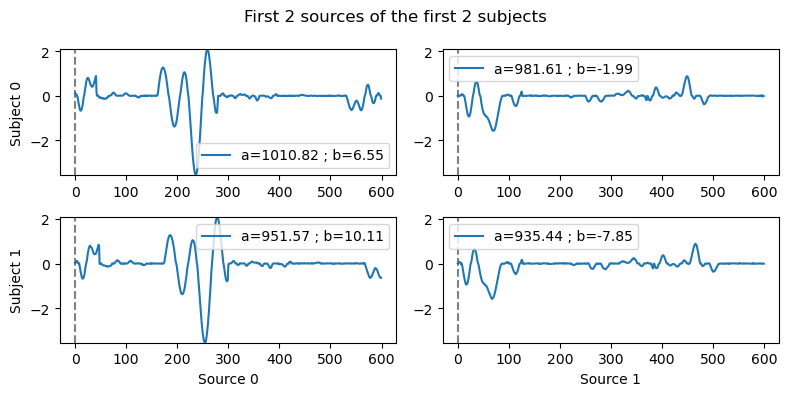

In [24]:
# plot 2 sources of 2 subjects
plt.subplots(2, 2, figsize=(8, 4))

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.plot(S_list[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"First 2 sources of the first 2 subjects")
plt.tight_layout()
plt.show()

In [25]:
def loss_jax_3d(A_B, S1, S2, t0):
    m, p, _ = S1.shape
    A = A_B[:m*p].reshape((m, p))
    B = A_B[m*p:].reshape((m, p))
    S2_d = apply_both_delays_3d_cyclic(S2, A=A, B=B, t0=t0)
    return jnp.mean((S1 - S2_d) ** 2)

In [26]:
val_and_grad_3d = jax.jit(jax.value_and_grad(loss_jax_3d))

def wrapper_loss_and_grad_3d(A_B, S_d, S, t0):
    loss, grad = val_and_grad_3d(A_B, S_d, S, t0)
    return loss, np.array(grad)

In [27]:
A_B_init = jnp.concatenate([jnp.ravel(jnp.ones((m, p)) * cste), jnp.ravel(jnp.zeros((m, p)))])

In [28]:
# smoothing S_list
def convolve_3d(S_list, filter_length=10):
    m, p, n = S_list.shape
    filter = np.ones(filter_length) / filter_length
    S_list_smooth = np.zeros((m, p, n))
    for i in range(m):
        S_list_smooth[i] = np.array([np.convolve(s, filter, mode='same') for s in S_list[i]])
    return S_list_smooth

S_list_smooth = convolve_3d(S_list, filter_length=15)

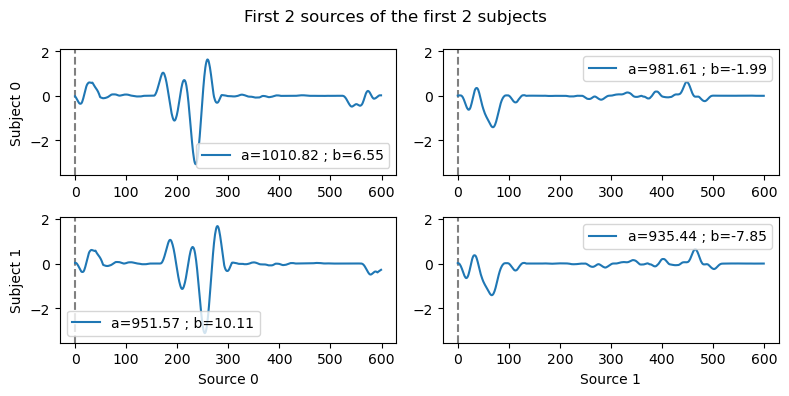

In [29]:
# plot 2 sources of 2 subjects
plt.subplots(2, 2, figsize=(8, 4))

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.plot(S_list_smooth[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"First 2 sources of the first 2 subjects")
plt.tight_layout()
plt.show()

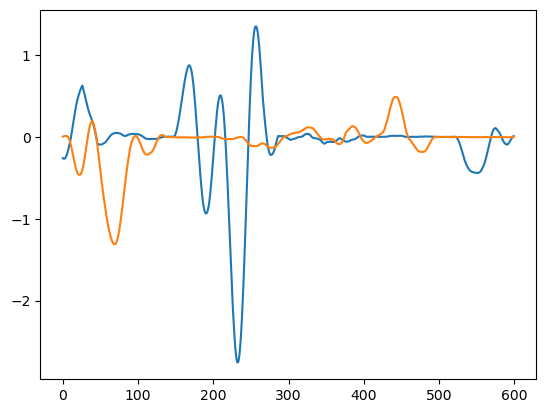

In [30]:
S_rep = np.array([S] * m)
S_rep_smooth = S_rep + noise_data * rng.randn(m, p, n)
S_rep_smooth = convolve_3d(S_rep_smooth, filter_length=20)

plt.plot(S_rep_smooth[0].T);

In [31]:
# bounds
bounds_A = [(1/max_dilation*cste**2, max_dilation)] * (m * p)
bounds_B = [(-max_shift, max_shift)] * (m * p)
bounds_A_B = jnp.array(bounds_A + bounds_B)

In [32]:
# jit
start = time()
wrapper_loss_and_grad_3d(A_B_init, S_list, S_rep_smooth, t0)
print(f"time : {time() - start}")

time : 3.760747194290161


In [33]:
# LBFGSB
res_lbfgsb_3d = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad_3d,
    x0=A_B_init,
    args=(S_list, S_rep, t0),
    bounds=bounds_A_B,
    disp=True,
    factr=0,
    pgtol=1e-6,
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98430D-01    |proj g|=  1.05738D-02

At iterate    1    f=  3.98173D-01    |proj g|=  1.05497D-02
  ys=-5.076E-06  -gs= 2.516E-04 BFGS update SKIPPED

At iterate    2    f=  3.77120D-01    |proj g|=  8.58448D-03

At iterate    3    f=  2.40161D-01    |proj g|=  9.83900D-03

At iterate    4    f=  9.21813D-02    |proj g|=  8.90690D-03

At iterate    5    f=  5.20217D-02    |proj g|=  4.83977D-03

At iterate    6    f=  3.42372D-02    |proj g|=  3.82858D-04

At iterate    7    f=  3.39604D-02    |proj g|=  4.66556D-04

At iterate    8    f=  3.36784D-02    |proj g|=  2.87301D-04

At iterate    9    f=  3.29045D-02    |proj g|=  4.32879D-04

At iterate   10    f=  3.19017D-02    |proj g|=  6.17621D-04

At iterate   11    f=  3.02966D-02    |proj g|=  1.05701D-03

At iterate   12    f=  2.86780D-02  

In [34]:
A_B_lbfgsb = res_lbfgsb_3d[0]
A_lbfgsb = A_B_lbfgsb[:m*p].reshape((m, p))
B_lbfgsb = A_B_lbfgsb[m*p:].reshape((m, p))

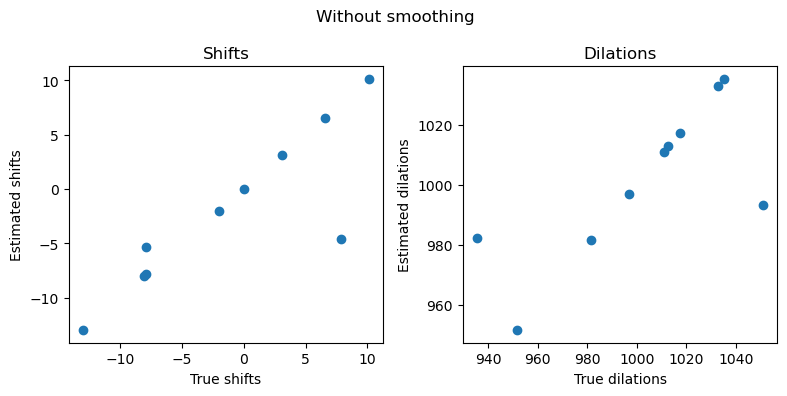

In [35]:
# scatter plots
plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(shifts, B_lbfgsb)
plt.title("Shifts")
plt.xlabel("True shifts")
plt.ylabel("Estimated shifts")

plt.subplot(1, 2, 2)
plt.scatter(dilations, A_lbfgsb)
plt.title("Dilations")
plt.xlabel("True dilations")
plt.ylabel("Estimated dilations")

plt.suptitle("Without smoothing")

plt.tight_layout()
plt.show()

So, the problem comes from the fact that, with our data generation, LBFGSB isn't even able to estimate dilations and shifts when the loss is only the square norm part.

# include smoothing into loss

In [36]:
filter_length = 15

In [37]:
def convolve_3d_jax(S_list):
    m, p, n = S_list.shape
    filter = jnp.ones(filter_length) / filter_length
    S_list_smooth = jnp.zeros((m, p, n))
    for i in range(m):
        S_list_smooth = S_list_smooth.at[i].set(jnp.array([jnp.convolve(s, filter, mode='same') for s in S_list[i]]))
    return S_list_smooth

def loss_jax_3d_smoothing(A_B, S1, S2, t0):
    m, p, _ = S1.shape
    A = A_B[:m*p].reshape((m, p))
    B = A_B[m*p:].reshape((m, p))
    S2_d = apply_both_delays_3d_cyclic(S2, A=A, B=B, t0=t0)
    return jnp.mean((convolve_3d_jax(S1) - convolve_3d_jax(S2_d)) ** 2)

In [38]:
val_and_grad_3d_smoothing = jax.jit(jax.value_and_grad(loss_jax_3d_smoothing))

def wrapper_loss_and_grad_3d_smoothing(A_B, S_d, S, t0):
    loss, grad = val_and_grad_3d_smoothing(A_B, S_d, S, t0)
    return loss, np.array(grad)

In [39]:
# jit
start = time()
wrapper_loss_and_grad_3d_smoothing(A_B_init, S_list, S_rep, t0)
print(f"time : {time() - start}")

time : 5.454818964004517


In [40]:
# LBFGSB
res_lbfgsb_3d_smooth = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad_3d_smoothing,
    x0=A_B_init,
    args=(S_list, S_rep, t0),
    bounds=bounds_A_B,
    disp=True,
    factr=0,
    pgtol=1e-6,
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60718D-01    |proj g|=  7.20517D-03

At iterate    1    f=  2.60597D-01    |proj g|=  7.19762D-03
  ys=-2.323E-06  -gs= 1.190E-04 BFGS update SKIPPED

At iterate    2    f=  1.28366D-01    |proj g|=  5.48678D-03

At iterate    3    f=  8.14985D-02    |proj g|=  6.41029D-03

At iterate    4    f=  2.90415D-02    |proj g|=  4.33237D-03

At iterate    5    f=  2.52141D-02    |proj g|=  3.96812D-03

At iterate    6    f=  1.42377D-02    |proj g|=  3.27896D-04

At iterate    7    f=  1.39713D-02    |proj g|=  2.69728D-04

At iterate    8    f=  1.30679D-02    |proj g|=  1.88033D-04

At iterate    9    f=  1.28901D-02    |proj g|=  2.65301D-04

At iterate   10    f=  1.27301D-02    |proj g|=  2.31266D-04

At iterate   11    f=  1.19963D-02    |proj g|=  4.57386D-04

At iterate   12    f=  1.11426D-02  

In [41]:
A_B_lbfgsb_smooth = res_lbfgsb_3d_smooth[0]
A_lbfgsb_smooth = A_B_lbfgsb_smooth[:m*p].reshape((m, p))
B_lbfgsb_smooth = A_B_lbfgsb_smooth[m*p:].reshape((m, p))

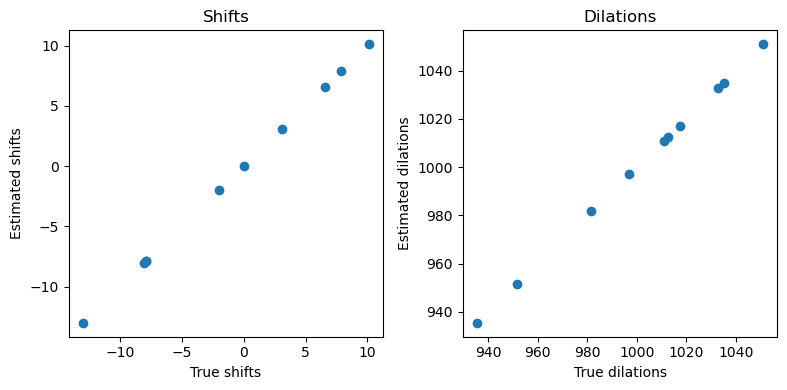

In [42]:
# scatter plots
plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(shifts, B_lbfgsb_smooth)
plt.title("Shifts")
plt.xlabel("True shifts")
plt.ylabel("Estimated shifts")

plt.subplot(1, 2, 2)
plt.scatter(dilations, A_lbfgsb_smooth)
plt.title("Dilations")
plt.xlabel("True dilations")
plt.ylabel("Estimated dilations")

plt.tight_layout()
plt.show()

# quantify smoothing effect

In [43]:
def run_experiment_smoothing_effect(random_state=0, noise_data=0.1):
    rng = check_random_state(random_state)
    # generate data
    X_list, A_list, dilations, shifts, S_list, S = gen_data(
        m=m,
        p=p,
        n=n,
        nb_intervals=nb_intervals,
        nb_freqs=nb_freqs,
        threshold=threshold,
        max_dilation=max_dilation,
        max_shift=max_shift,
        t0=t0,
        noise_data=noise_data,
        rng=rng,
    )
    
    # initial parameters
    A_B_init = jnp.concatenate([jnp.ravel(jnp.ones((m, p)) * cste), jnp.ravel(jnp.zeros((m, p)))])
    S_rep = np.array([S] * m)

    # bounds
    bounds_A = [(1/max_dilation*cste**2, max_dilation)] * (m * p)
    bounds_B = [(-max_shift, max_shift)] * (m * p)
    bounds_A_B = jnp.array(bounds_A + bounds_B)
    
    # LBFGSB without smoothing
    res_lbfgsb_3d = fmin_l_bfgs_b(
        func=wrapper_loss_and_grad_3d,
        x0=A_B_init,
        args=(S_list, S_rep, t0),
        bounds=bounds_A_B,
        disp=False,
        factr=0,
        pgtol=1e-6,
    )
    A_B_lbfgsb = res_lbfgsb_3d[0]
    A_lbfgsb = A_B_lbfgsb[:m*p].reshape((m, p))
    B_lbfgsb = A_B_lbfgsb[m*p:].reshape((m, p))
    
    # LBFGSB with smoothing
    res_lbfgsb_3d_smooth = fmin_l_bfgs_b(
        func=wrapper_loss_and_grad_3d_smoothing,
        x0=A_B_init,
        args=(S_list, S_rep, t0),
        bounds=bounds_A_B,
        disp=False,
        factr=0,
        pgtol=1e-6,
    )
    A_B_lbfgsb_smooth = res_lbfgsb_3d_smooth[0]
    A_lbfgsb_smooth = A_B_lbfgsb_smooth[:m*p].reshape((m, p))
    B_lbfgsb_smooth = A_B_lbfgsb_smooth[m*p:].reshape((m, p))
    
    # divide dilations by constant
    dilations /= cste
    A_lbfgsb_smooth /= cste
    A_lbfgsb /= cste
    
    # compute errors
    shifts_error_no_smoothing = np.mean(np.abs(B_lbfgsb - shifts))
    shifts_error_smoothing = np.mean(np.abs(B_lbfgsb_smooth - shifts))
    dilations_error_no_smoothing = np.mean(np.abs(A_lbfgsb - dilations))
    dilations_error_smoothing = np.mean(np.abs(A_lbfgsb_smooth - dilations))
    
    # errors random
    nb_seeds_random = 10
    shifts_error_random = 0
    dilations_error_random = 0
    for _ in range(nb_seeds_random):
        shifts_random = rng.uniform(low=-max_shift, high=max_shift, size=np.shape(shifts))
        shifts_error_random += np.mean(np.abs(shifts_random - shifts))
        dilations_random = rng.uniform(low=1/max_dilation*cste, high=max_dilation/cste, size=np.shape(dilations))  # XXX
        dilations_error_random += np.mean(np.abs(dilations_random - dilations))
    shifts_error_random /= nb_seeds_random
    dilations_error_random /= nb_seeds_random
    
    dict_res = {"shifts_error_no_smoothing": [shifts_error_no_smoothing],
                "shifts_error_smoothing": [shifts_error_smoothing],
                "shifts_error_random": [shifts_error_random],
                "dilations_error_no_smoothing": [dilations_error_no_smoothing],
                "dilations_error_smoothing": [dilations_error_smoothing],
                "dilations_error_random": [dilations_error_random]}
    
    return dict_res

In [44]:
# ~0.5sec per seed
noise_data = 0.05
nb_seeds = 30
df_res = pd.DataFrame()
for random_state in range(nb_seeds):
    dict_expe = run_experiment_smoothing_effect(random_state, noise_data)
    df_expe = pd.DataFrame(dict_expe)
    df_res = pd.concat([df_res, df_expe], ignore_index=True)

In [45]:
mean_shifts_error_random = np.mean(df_res['shifts_error_random'])
mean_dilations_error_random = np.mean(df_res['dilations_error_random'])

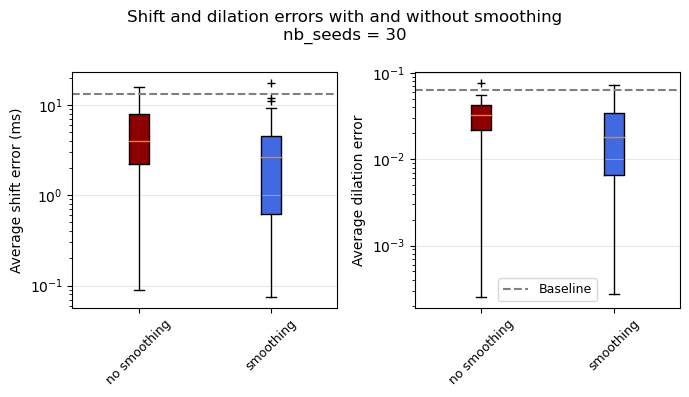

In [46]:
# plot
def one_subplot(data, ylabel, ax, logscale=False, average=None):
    bp = ax.boxplot(data)
    ax.set(ylabel=ylabel)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    plt.setp(bp['fliers'], color='red', marker='+')
    box_colors = ['darkred', 'royalblue']
    nb_algos = len(data)
    for i in range(nb_algos):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        ax.add_patch(Polygon(box_coords, facecolor=box_colors[i]))
    ax.set_xticklabels(
        ['no smoothing', 'smoothing'],
        rotation=45, fontsize=9)
    if logscale is True:
        ax.set_yscale('log')
    if average is not None:
        ax.axhline(average, c='grey', linestyle='--')

fig, axs = plt.subplots(1, 2, figsize=(7, 4))

one_subplot(
    [df_res['shifts_error_no_smoothing'], df_res['shifts_error_smoothing']],
    'Average shift error (ms)',
    axs[0],
    logscale=True,
    average=mean_shifts_error_random)
one_subplot(
    [df_res['dilations_error_no_smoothing'], df_res['dilations_error_smoothing']],
    'Average dilation error',
    axs[1],
    logscale=True,
    average=mean_dilations_error_random)

plt.legend([Line2D([0], [0], linestyle='--', color='grey', lw=1.5)], ['Baseline'], fontsize=9)

plt.suptitle(f"Shift and dilation errors with and without smoothing\nnb_seeds = {nb_seeds}")
plt.tight_layout()

# plot topomap of total loss

Use m subjects, p sources and n samples. Plot topomap of a and b of the first source of the first subject. The goal is to see if it is smooth or not. My assumpation is that the topomap will be chaotic because of noise, and that it explains why we badly estimate dilations and shifts.

# estimate unmixing matrices with smoothing

In [47]:
def convolve_2d_jax(S):
    filter = jnp.ones(filter_length) / filter_length
    return jnp.array([jnp.convolve(s, filter, mode='same') for s in S])

In [48]:
def _logcosh(X):
    Y = jnp.abs(X)
    return Y + jnp.log1p(jnp.exp(-2 * Y))

def loss_W_A_B_smoothing(W_list, dilations, shifts, X_list, noise_model=1, t0=0):
    _, p, _ = X_list.shape
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    Y_list = apply_both_delays_3d_cyclic(S_list, A=1/dilations, B=-shifts, t0=t0)
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    for W, Y in zip(W_list, Y_list):
        loss -= jnp.linalg.slogdet(W)[1]
        # loss += 1 / (2 * noise_model) * jnp.mean((Y - Y_avg) ** 2) * p
        loss += 1 / (2 * noise_model) * jnp.mean((convolve_2d_jax(Y) - convolve_2d_jax(Y_avg)) ** 2) * p
    return loss

def vector_to_parameters(W_delays, m, p):
    W_list = W_delays[:m*p**2].reshape((m, p, p))
    dilations = W_delays[m*p**2: m*p*(p+1)].reshape((m, p))
    shifts = W_delays[m*p*(p+1):].reshape((m, p))
    return W_list, dilations, shifts

def wrapped_loss_W_A_B_smoothing(W_delays, *args):
    return loss_W_A_B_smoothing(*vector_to_parameters(W_delays, m, p), *args)

In [49]:
val_and_grad_W_A_B_smoothing = jax.jit(jax.value_and_grad(wrapped_loss_W_A_B_smoothing))

def wrapper_loss_and_grad_W_A_B_smoothing(W_delays, X_list, noise_model, t0):
    loss, grad = val_and_grad_W_A_B_smoothing(W_delays, X_list, noise_model, t0)
    return loss, np.array(grad)

In [50]:
# generate data
random_state = 2352
noise_data = 0.02  # XXX
rng = check_random_state(random_state)
X_list, A_list, dilations, shifts, S_list, S = gen_data(
    m=m,
    p=p,
    n=n,
    nb_intervals=nb_intervals,
    nb_freqs=nb_freqs,
    threshold=threshold,
    max_dilation=max_dilation,
    max_shift=max_shift,
    t0=t0,
    noise_data=noise_data,
    rng=rng,
)

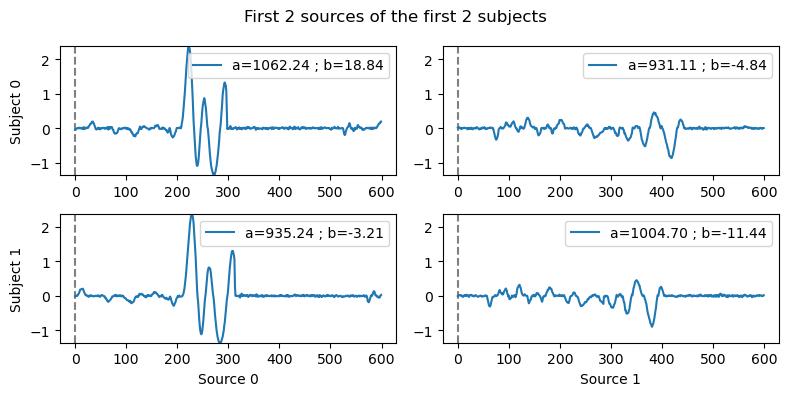

In [51]:
# plot 2 sources of 2 subjects
plt.subplots(2, 2, figsize=(8, 4))

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.plot(S_list[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"First 2 sources of the first 2 subjects")
plt.tight_layout()
plt.show()

In [52]:
# initialization parameters
W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + 0.2 * rng.randn(m, p, p)
dilations_init = jnp.ones((m, p)) * cste  # XXX
shifts_init = jnp.zeros((m, p))
W_delays_init = jnp.concatenate(
    [jnp.ravel(W_list_init), jnp.ravel(dilations_init), jnp.ravel(shifts_init)])

In [53]:
# jit
start = time()
wrapper_loss_and_grad_W_A_B_smoothing(W_delays_init, X_list, noise_model, t0)
print(f"time : {time() - start}")

time : 10.333529472351074


In [54]:
# bounds
bounds_W = [(-jnp.inf, jnp.inf)] * (m * p ** 2)
bounds_shifts = [(-max_shift, max_shift)] * (m * p)
bounds_dilations = [(1/max_dilation*cste**2, max_dilation)] * (m * p)  # XXX
bounds_W_dilations_shifts = jnp.array(bounds_W + bounds_dilations + bounds_shifts)

In [55]:
# LBFGSB
res_lbfgsb_W_A_B_smooth = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad_W_A_B_smoothing,
    x0=W_delays_init,
    args=(X_list, noise_model, t0),
    bounds=bounds_W_dilations_shifts,
    disp=True,
    factr=0,
    pgtol=1e-6,
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           40     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36742D+00    |proj g|=  2.66798D+00

At iterate    1    f= -2.28782D+00    |proj g|=  1.07755D+00

At iterate    2    f= -5.15086D+00    |proj g|=  6.70565D-01

At iterate    3    f= -9.54151D+00    |proj g|=  3.94342D-01

At iterate    4    f= -1.37825D+01    |proj g|=  2.38312D-01

At iterate    5    f= -1.81151D+01    |proj g|=  1.38719D-01

At iterate    6    f= -2.22176D+01    |proj g|=  8.22891D-02

At iterate    7    f= -2.59964D+01    |proj g|=  4.75087D-02

At iterate    8    f= -2.94349D+01    |proj g|=  3.15639D-02

At iterate    9    f= -3.15517D+01    |proj g|=  3.78058D-01

At iterate   10    f= -3.46174D+01    |proj g|=  2.79152D-02

At iterate   11    f= -3.58137D+01    |proj g|=  3.77769D-02

At iterate   12    f= -4.09553D+01    |proj g|=  5.42513D-02

At iterate   13    f= -4.2

In [56]:
# change results' shape
W_A_B_smooth = res_lbfgsb_W_A_B_smooth[0]
W_smooth = W_A_B_smooth[:m*p**2].reshape((m, p, p))
A_smooth = W_A_B_smooth[m*p**2: m*p*(p+1)].reshape((m, p))
B_smooth = W_A_B_smooth[m*p*(p+1):].reshape((m, p))

In [57]:
# divide dilations by constant
dilations /= cste
A_smooth /= cste

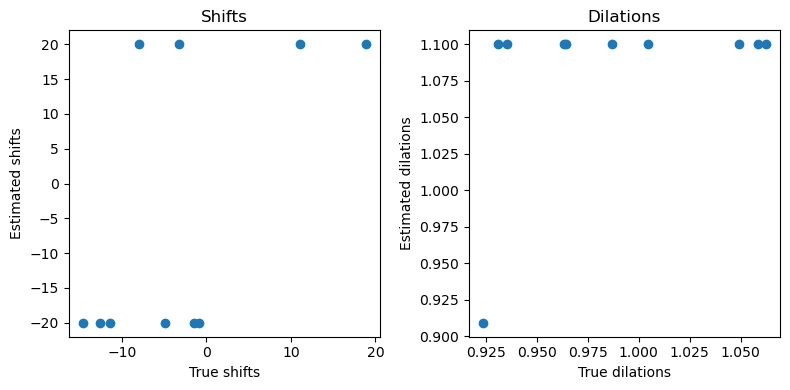

In [58]:
# scatter plots
plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(shifts, B_smooth)
plt.title("Shifts")
plt.xlabel("True shifts")
plt.ylabel("Estimated shifts")

plt.subplot(1, 2, 2)
plt.scatter(dilations, A_smooth)
plt.title("Dilations")
plt.xlabel("True dilations")
plt.ylabel("Estimated dilations")

plt.tight_layout()
plt.show()

In [59]:
# reconstruct sources
S_list_smooth = np.array([np.dot(W, X) for W, X in zip(W_smooth, X_list)])

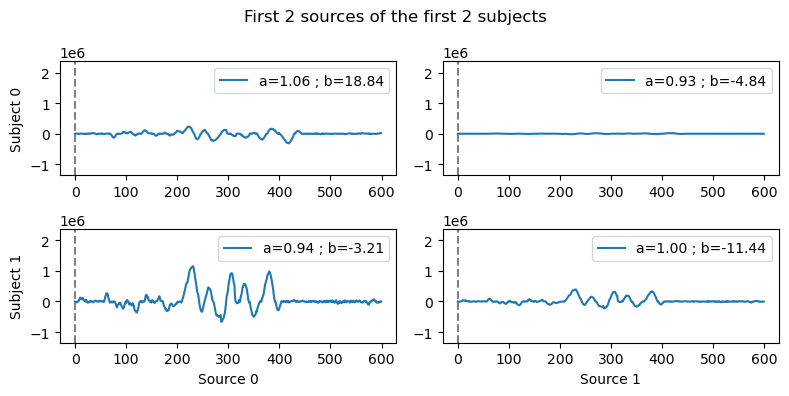

In [60]:
# plot 2 sources of 2 subjects
plt.subplots(2, 2, figsize=(8, 4))

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.plot(S_list_smooth[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list_smooth), ymax=np.max(S_list_smooth), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list_smooth), np.max(S_list_smooth)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"First 2 sources of the first 2 subjects")
plt.tight_layout()
plt.show()

Maybe the data generation is not appropriate.

# try new data generation (less flat)

In [61]:
from multiviewica_delay import data_generation

In [86]:
# parameters
m = 5
p = 2
n = 600
max_delay = 20
noise_data = 0.03
shared_delays = False
random_state = 0
n_concat = 1

# generate data
X_list, A_list, shifts, S_list, S = data_generation(
    m=m,
    p=p,
    n=n,
    max_delay=max_delay,
    noise=noise_data,
    shared_delays=shared_delays,
    random_state=random_state,
    n_concat=n_concat
)

In [87]:
shifts

array([[  0,   0],
       [  1,   0],
       [ 10, 592],
       [  0, 594],
       [583,  10]])

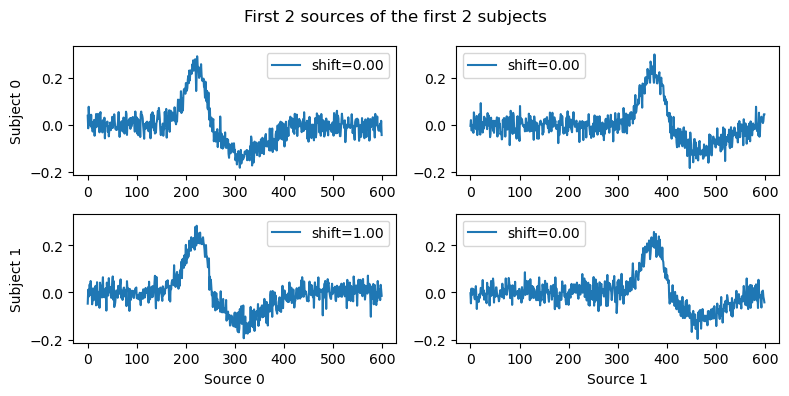

In [88]:
# plot 2 sources of 2 subjects
plt.subplots(2, 2, figsize=(8, 4))

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.plot(S_list[i, j], label=f'shift={shifts[i, j]:.2f}')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"First 2 sources of the first 2 subjects")
plt.tight_layout()
plt.show()

In [89]:
# initialization parameters
W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + 0.2 * rng.randn(m, p, p)
dilations_init = jnp.ones((m, p)) * cste  # XXX
shifts_init = jnp.zeros((m, p))
W_delays_init = jnp.concatenate(
    [jnp.ravel(W_list_init), jnp.ravel(dilations_init), jnp.ravel(shifts_init)])

In [90]:
# jit
start = time()
wrapper_loss_and_grad_W_A_B_smoothing(W_delays_init, X_list, noise_model, t0)
print(f"time : {time() - start}")

time : 0.0034923553466796875


In [91]:
# LBFGSB
res_lbfgsb_W_A_B_smooth = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad_W_A_B_smoothing,
    x0=W_delays_init,
    args=(X_list, noise_model, t0),
    bounds=bounds_W_dilations_shifts,
    disp=True,
    factr=0,
    pgtol=1e-6,
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           40     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40166D+00    |proj g|=  1.95051D+01

At iterate    1    f= -5.09856D+00    |proj g|=  1.68604D+00

At iterate    2    f= -5.60754D+00    |proj g|=  1.34077D+00

At iterate    3    f= -9.07913D+00    |proj g|=  6.14874D-01

At iterate    4    f= -1.23165D+01    |proj g|=  3.87581D-01

At iterate    5    f= -1.59706D+01    |proj g|=  2.27886D-01

At iterate    6    f= -1.96365D+01    |proj g|=  1.35882D-01

At iterate    7    f= -2.31761D+01    |proj g|=  8.07132D-02

At iterate    8    f= -2.62797D+01    |proj g|=  4.93164D-02

At iterate    9    f= -2.91251D+01    |proj g|=  6.23448D-02

At iterate   10    f= -3.37579D+01    |proj g|=  1.20596D-01

At iterate   11    f= -3.48535D+01    |proj g|=  4.53398D-02

At iterate   12    f= -3.69350D+01    |proj g|=  1.18714D-01

At iterate   13    f= -3.9


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate 7823    f= -8.50354D+01    |proj g|=  3.50410D-06

At iterate 7824    f= -8.50354D+01    |proj g|=  3.45872D-06

At iterate 7825    f= -8.50354D+01    |proj g|=  3.45815D-06

At iterate 7826    f= -8.50354D+01    |proj g|=  3.45813D-06

At iterate 7827    f= -8.50354D+01    |proj g|=  2.94149D-06

At iterate 7828    f= -8.50354D+01    |proj g|=  1.61608D-06

At iterate 7829    f= -8.50354D+01    |proj g|=  2.58222D-06

At iterate 7830    f= -8.50354D+01    |proj g|=  2.34079D-06

At iterate 7831    f= -8.50354D+01    |proj g|=  2.36861D-06

At iterate 7832    f= -8.50354D+01    |proj g|=  1.21388D-06

At iterate 7833    f= -8.50354D+01    |proj g|=  1.61075D-06

At iterate 7834    f= -8.50354D+01    |proj g|=  4.20322D-06

At iterate 7835    f= -8.50354D+01    |proj g|=  4.77215D-06

At iterate 7836    f= -8.50354D+01    |proj g|=  4.98759D-06

At iterate 7837    f= -8.50354D+01    |proj g|=  2.99648D-06

At iterate 7838    f= -8.50354D+01    |proj g|=  8.99008D-06




 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


At iterate 7839    f= -8.50354D+01    |proj g|=  8.17431D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   40   7839   8473   7854     0    19   8.174D-07  -8.504D+01
  F =  -85.035356885789653     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [92]:
# change results' shape
W_A_B_smooth = res_lbfgsb_W_A_B_smooth[0]
W_smooth = W_A_B_smooth[:m*p**2].reshape((m, p, p))
A_smooth = W_A_B_smooth[m*p**2: m*p*(p+1)].reshape((m, p))
B_smooth = W_A_B_smooth[m*p*(p+1):].reshape((m, p))

In [95]:
shifts[shifts > n // 2] -= n

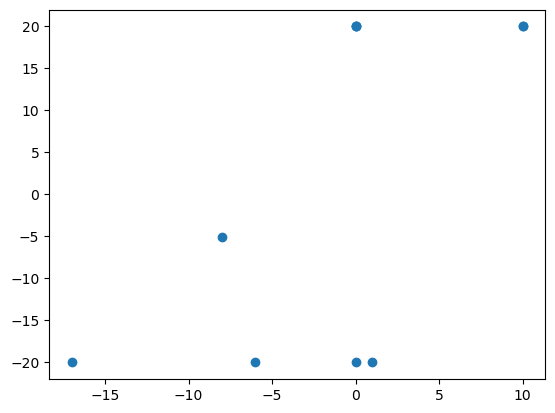

In [96]:
plt.scatter(shifts, B_smooth)